In [1]:
import numpy as np
from regain.data.base import load_commodities_data,load_ETF_data
from regain.hmm.hmm_graphical_lasso import HMM_GraphicalLasso 
from regain.hmm.utils import corr_plot,plot_results_cluster,cov2corr,cluster_returns_recap,cross_validation
from regain.hmm.utils_pred import pred_HMM_GMM,pred_from_N_past_days,returns_recap,corr_pred_plot
import matplotlib.pyplot as plt

/Users/federicociech/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# load data

data = load_commodities_data(type_data = 1)
print(data)

     VIX Index  OVX Index  XAU Curncy  XAG Curncy  DXY Curncy        M2  \
0    -7.343825  -1.330604   -0.730649   -0.201163   -0.316442  5.282669   
1   -10.808029   3.181189   -1.089916    0.493755   -0.956573  5.809859   
2     5.770340   5.110590    0.700505    0.419075    0.412393 -6.455907   
3    -8.074195   0.653595   -0.356876   -0.618794   -0.443683  4.073284   
4     2.611276  -3.658537   -2.433548   -3.123081    1.206596  1.982567   
..         ...        ...         ...         ...         ...       ...   
984 -12.174721 -11.201473   -0.053146   -0.440868    0.163028  2.574526   
985   0.634921  -5.581476   -0.601276   -0.543333    0.303892 -0.264201   
986  -2.786540  -1.189605    0.508621    1.249496   -0.598753 -2.168874   
987   1.622499  -0.055566    0.244016   -0.102607   -0.008266  1.387714   
988  -3.831825   3.854707   -0.301419   -0.747635    0.510447 -0.751127   

     Trade_Date  
0    2015-01-02  
1    2015-01-05  
2    2015-01-06  
3    2015-01-07  
4    2015

In [3]:
Dates = data['Trade_Date'].values
Dataset = data.drop(columns=['Trade_Date'])
Returns = Dataset.values

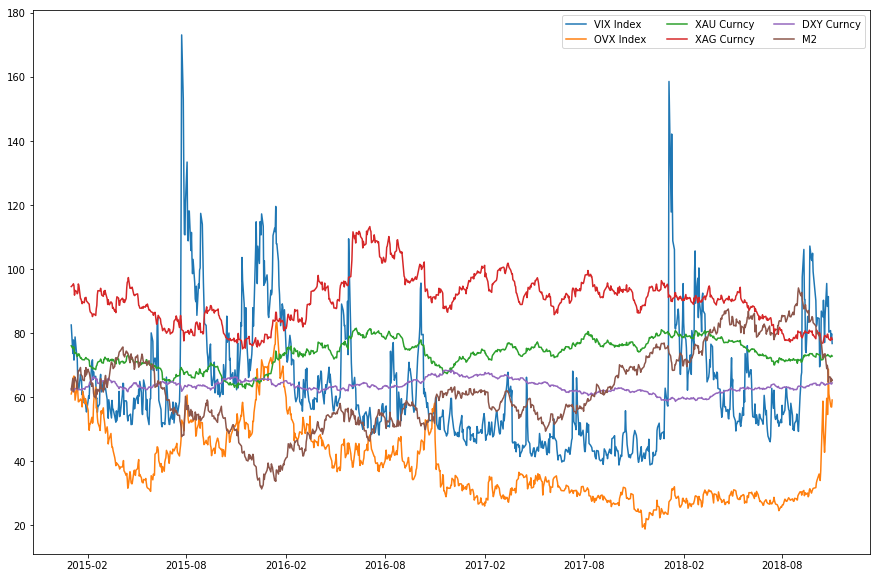

In [4]:
p_vec_0 = np.random.uniform(30,100,Returns.shape[1])
Data = np.zeros((np.size(Returns,axis=0)+1,Returns.shape[1]))
Data[0, :] = p_vec_0
for j in range(1, Returns.shape[0]+1):
    Data[j,:] =  Data[j-1,:] + Returns[j-1,:]*Data[j-1,:]/100
    
plt.figure(figsize= (15,10))
for i in range(Data.shape[1]):
    plt.plot(Dates, Data[1:, i], label = Dataset.columns[i])
plt.legend(ncol=3)
plt.show()

In [5]:
lam = 24.73684211
max_iter = 300
N_states = 3

mdl = HMM_GraphicalLasso(alpha=lam,
                         n_clusters=N_states,
                         verbose=False,
                         max_iter=max_iter,
                         mode='scaled',
                         warm_restart=True,
                         repetitions=50,
                         n_jobs=-1)
mdl.fit(Returns)

HMM_GraphicalLasso(alpha=24.73684211, init_params={}, max_iter=300,
                   mode='scaled', n_clusters=3, n_jobs=-1, repetitions=50,
                   tol=0.0001, verbose=False, warm_restart=True)

In [6]:
mdl.lambdas

array([0.03443648, 0.11917518, 0.39202301])

In [6]:
cluster_list = [2,3,4]

res = cross_validation(mdl,
                       Returns,
                       params={'alpha':np.linspace(10,50 ,20),
                               'n_clusters':cluster_list},
                       n_repetitions=3)

 33%|███▎      | 1/3 [11:33<23:07, 693.86s/it]

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

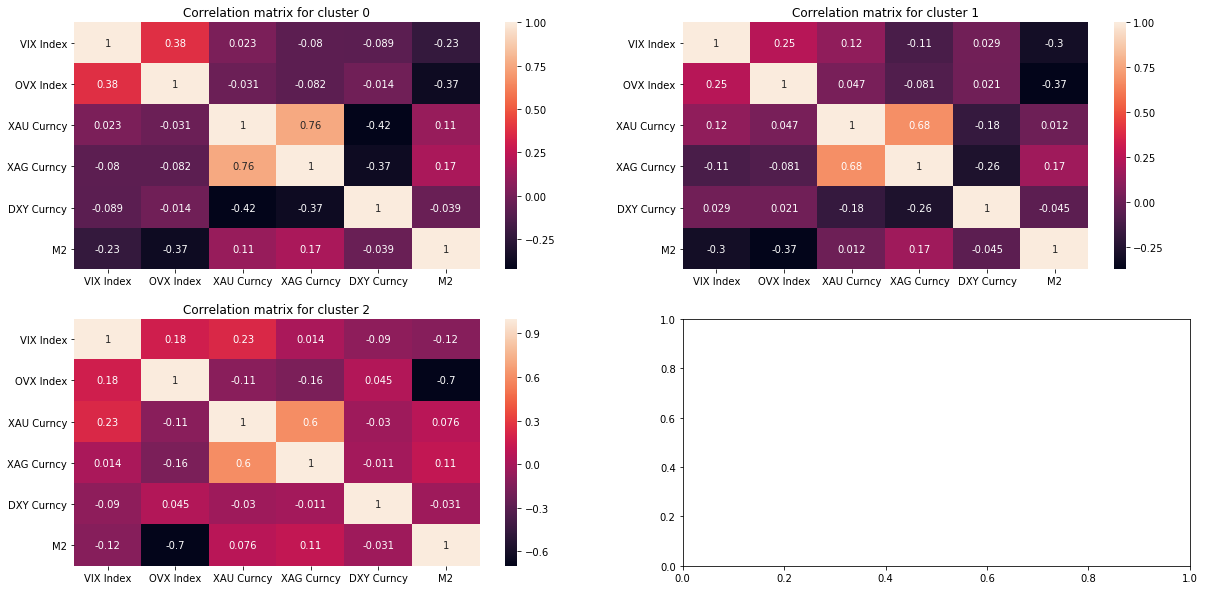

In [7]:
corr_plot(mdl.covariances_,labels = Dataset.columns,covcorr = True)

In [7]:
mdl.lambdas

array([0.04202841, 0.71489401, 0.65475608, 0.16007317])

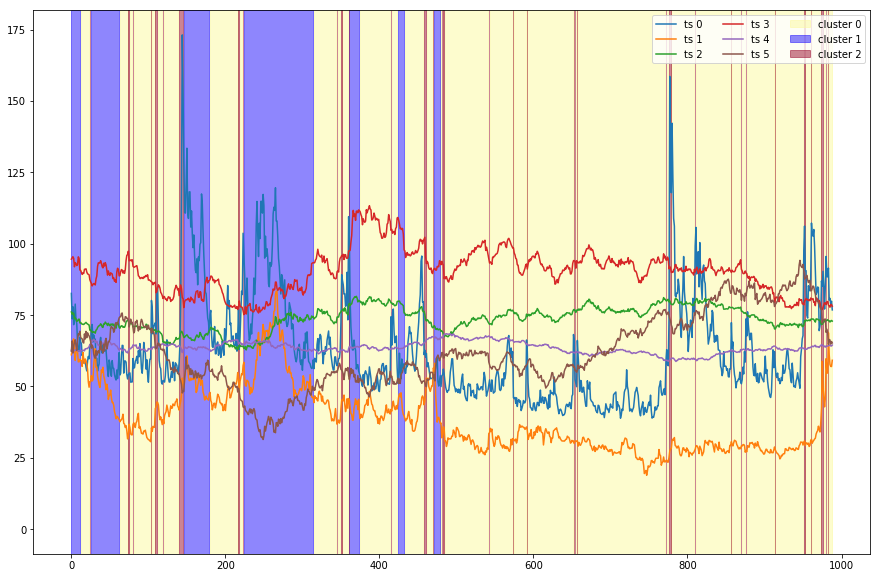

In [8]:
plot_results_cluster(Data, mdl.labels_, Dates, Dataset.columns)

In [9]:
cluster_returns_recap(mdl.means_, mdl.covariances_, Dataset.columns)

,Cluster,TS,mean,std,Prob positive return %,Prob negative return %
0,0,VIX Index,-0.303626,6.243067,47.925557,51.804463
1,0,OVX Index,-0.142903,3.759987,48.349147,51.380873
2,0,XAU Curncy,-0.012476,0.630478,49.075606,50.654415
3,0,XAG Curncy,-0.020737,1.050211,49.077346,50.652674
4,0,DXY Curncy,0.002561,0.397348,50.122115,49.607905
5,0,M2,0.066032,1.613135,51.497594,48.232426
6,1,VIX Index,-0.901741,7.120754,44.826452,54.903568
7,1,OVX Index,-0.492767,4.732455,45.718515,54.011506
8,1,XAU Curncy,0.049573,0.993634,51.854532,47.875488
9,1,XAG Curncy,0.185495,1.636015,54.378642,45.351379


In [12]:
# load data

data = load_commodities_data(type_data = 4)
print(data)

           M2        M3        M4        M5        M6        M7        M8  \
0    5.189658  5.282669  5.145455  4.959857  4.730203  4.460903  4.259291   
1    5.848583  5.809859  5.723673  5.609383  5.503513  5.391591  5.257161   
2   -6.508475 -6.455907 -6.346091 -6.180589 -6.009196 -5.851064 -5.659502   
3    4.260334  4.073284  3.911980  3.757077  3.609987  3.506148  3.376496   
4    2.034429  1.982567  1.932773  1.868386  1.839792  1.798041  1.744094   
..        ...       ...       ...       ...       ...       ...       ...   
984  2.857143  2.574526  2.464967  2.372938  2.315048  2.275008  2.237435   
985 -0.446429 -0.264201 -0.181249 -0.164393 -0.147565 -0.147203 -0.130655   
986 -2.408238 -2.168874 -2.129416 -2.058291 -2.003284 -1.965602 -1.913328   
987  1.276378  1.387714  1.315568  1.260928  1.239946  1.219716  1.183728   
988 -1.344312 -0.751127 -0.815715 -0.896563 -0.976498 -1.056454 -1.153403   

           M9       M10       M11       M12  Trade_Date  
0    4.152713  4.

In [13]:
Dates = data['Trade_Date'].values
Dataset = data.drop(columns=['Trade_Date'])
Returns = Dataset.values

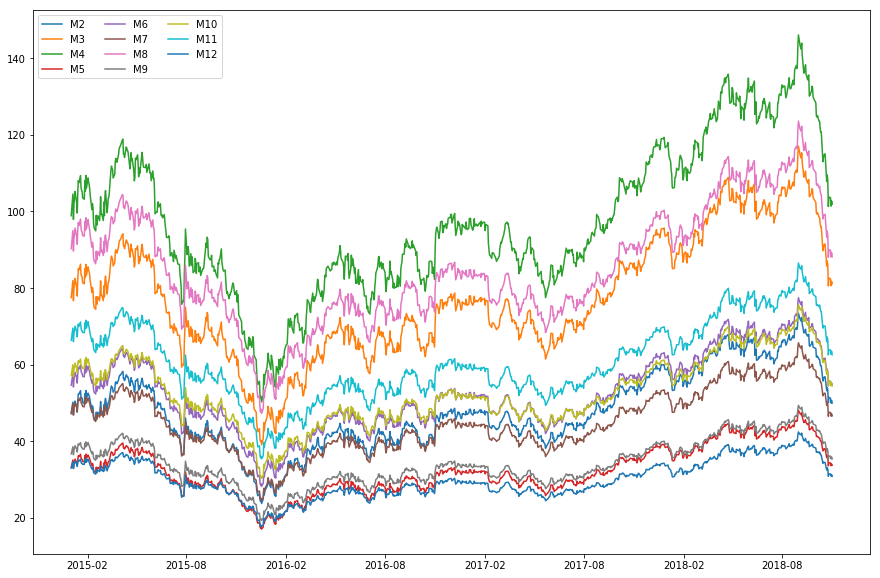

In [14]:
p_vec_0 = np.random.uniform(30,100,Returns.shape[1])
Data = np.zeros((np.size(Returns,axis=0)+1,Returns.shape[1]))
Data[0, :] = p_vec_0
for j in range(1, Returns.shape[0]+1):
    Data[j,:] =  Data[j-1,:] + Returns[j-1,:]*Data[j-1,:]/100
    
plt.figure(figsize= (15,10))
for i in range(Data.shape[1]):
    plt.plot(Dates, Data[1:, i], label = Dataset.columns[i])
plt.legend(ncol=3)
plt.show()

In [20]:
lam = 10
max_iter = 300
N_states = 2

mdl = HMM_GraphicalLasso(alpha=lam,
                         n_clusters=N_states,
                         verbose=False,
                         max_iter=max_iter,
                         mode='scaled',
                         warm_restart=True,
                         repetitions=50,
                         n_jobs=-1)
mdl.fit(Returns)

HMM_GraphicalLasso(alpha=10, init_params={}, max_iter=300, mode='scaled',
                   n_clusters=2, n_jobs=-1, repetitions=50, tol=0.0001,
                   verbose=False, warm_restart=True)

In [21]:
mdl.lambdas

array([0.01013161, 5.02428961])

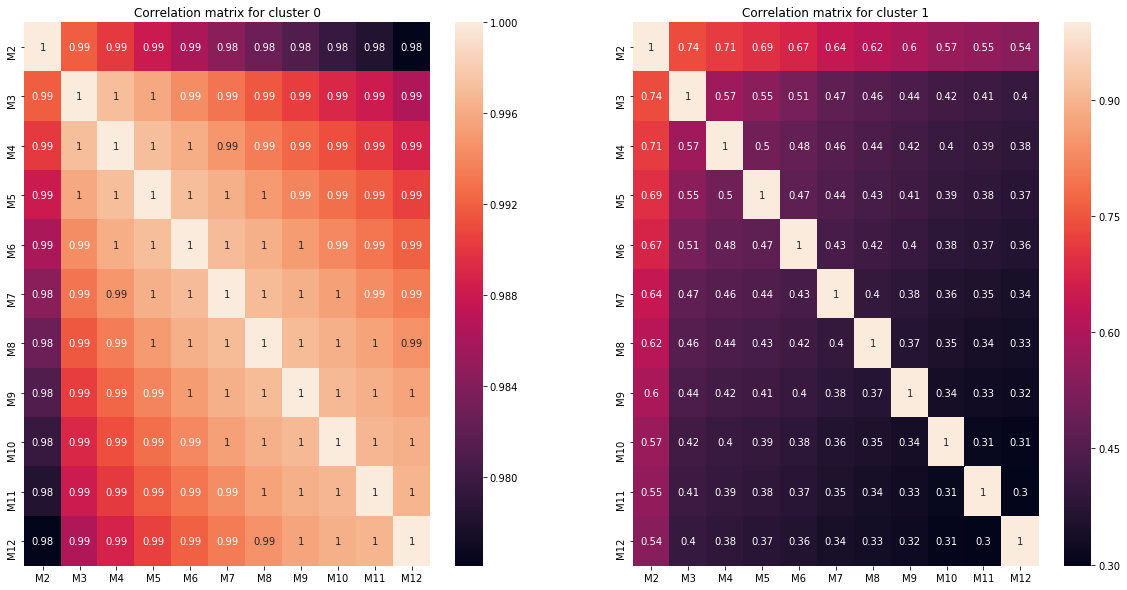

In [22]:
corr_plot(mdl.covariances_,labels = Dataset.columns,covcorr = True)

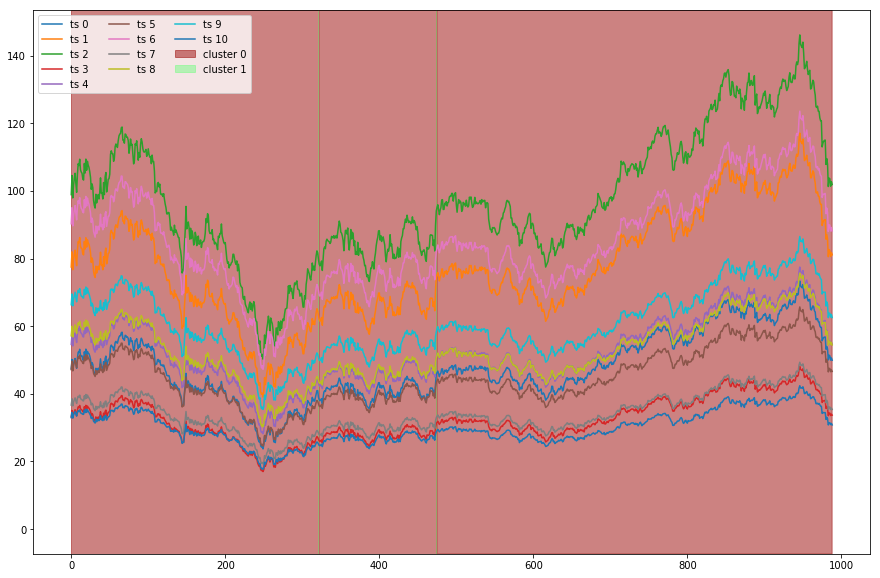

In [23]:
plot_results_cluster(Data, mdl.labels_, Dates, Dataset.columns)

In [24]:
cluster_returns_recap(mdl.means_, mdl.covariances_, Dataset.columns)

,Cluster,TS,mean,std,Prob positive return %,Prob negative return %
0,0,M2,0.033131,2.186857,50.469390,49.260631
1,0,M3,0.030813,2.150235,50.436685,49.293335
2,0,M4,0.028470,2.103462,50.404962,49.325059
3,0,M5,0.026239,2.057674,50.373728,49.356292
4,0,M6,0.023911,2.010446,50.339485,49.390536
5,0,M7,0.021633,1.965846,50.304010,49.426011
6,0,M8,0.019670,1.923121,50.273038,49.456983
7,0,M9,0.017741,1.881581,50.241150,49.488870
8,0,M10,0.015756,1.843181,50.206026,49.523994
9,0,M11,0.013933,1.805931,50.172787,49.557234


100%|██████████| 1/1 [01:51<00:00, 111.04s/it]


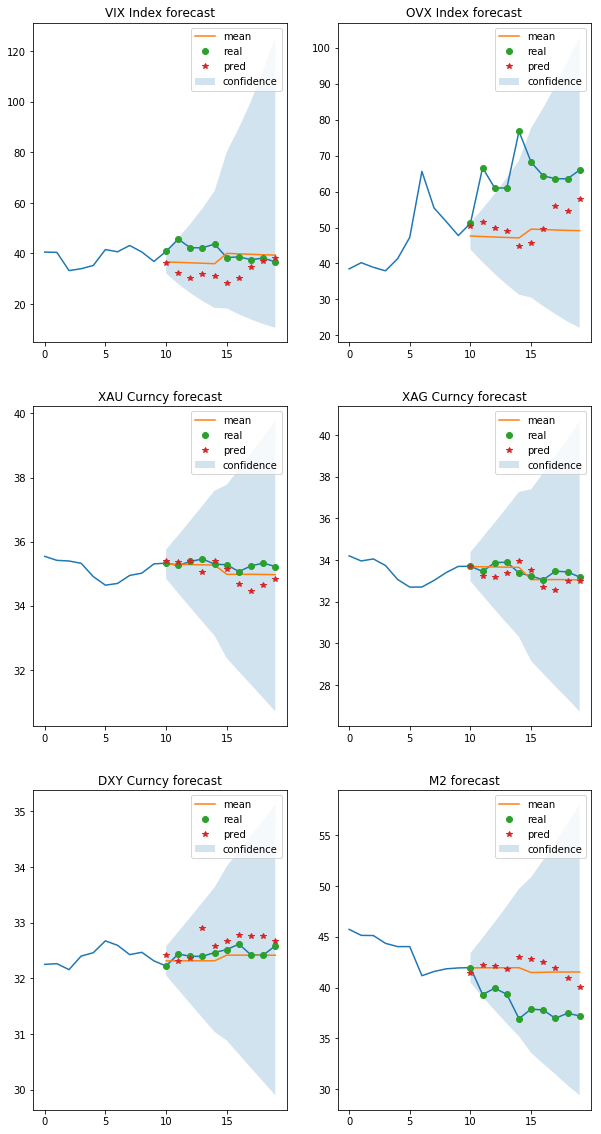

In [11]:
alpha_list = [lam]
cluster_list = [N_states]
N_pred = 10

results = pred_HMM_GMM(Returns,
                       Data,
                       alpha_list,
                       cluster_list,
                       N_test = N_pred,
                       columns = Dataset.columns,
                       meth = 'viterbi',
                       pred_meth = 'norolling',
                       recrossval = False,
                       perc_var = True)

100%|██████████| 1/1 [01:48<00:00, 108.33s/it]


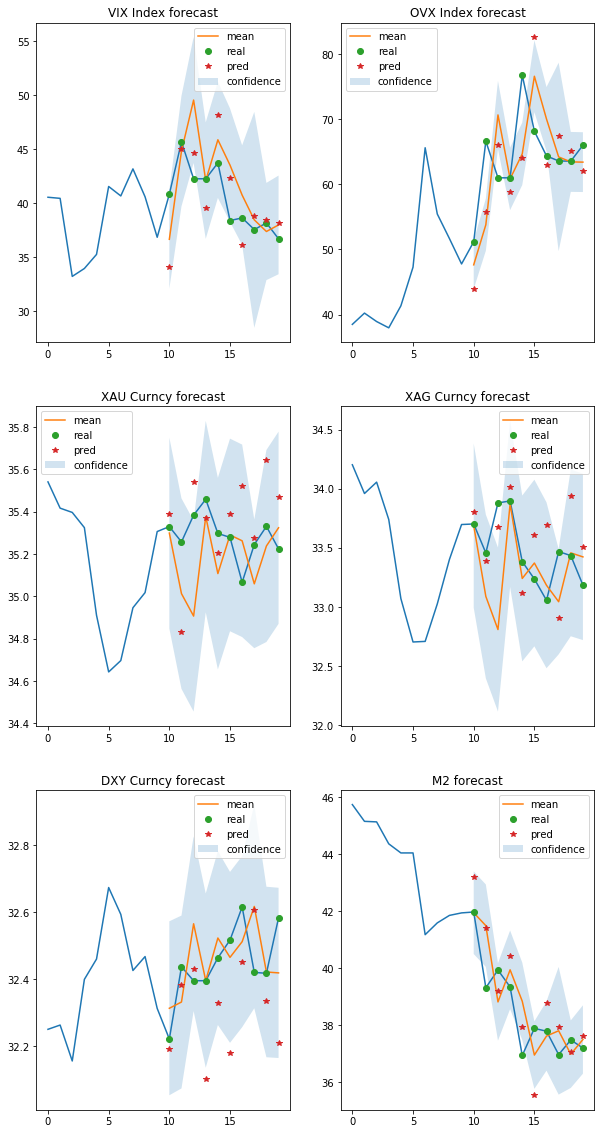

In [12]:
alpha_list = [lam]
cluster_list = [N_states]
N_pred = 10

results = pred_HMM_GMM(Returns,
                       Data,
                       alpha_list,
                       cluster_list,
                       N_test = N_pred,
                       columns = Dataset.columns,
                       meth = 'viterbi',
                       pred_meth = 'rolling',
                       recrossval = False,
                       perc_var = True)

In [2]:
# load data ETF

data = load_ETF_data()
print(data)

             VTI         SPY        EFA        VWO         TLT         IEF  \
0      55.983719  111.483650  53.489937  29.409512   58.628643   59.735962   
1      56.350910  111.979050  53.847092  29.783701   58.641998   59.793949   
2      56.538418  112.489952  54.025677  29.880840   58.460850   59.692425   
3      57.108776  113.558159  54.595730  30.255022   58.782974   59.757679   
4      57.198647  113.860085  54.602592  30.147093   59.111759   60.011406   
...          ...         ...        ...        ...         ...         ...   
3152  151.690002  298.399994  66.139999  41.380001  139.919998  111.889999   
3153  152.190002  299.279999  66.300003  41.509998  139.580002  111.849998   
3154  151.580002  297.970001  66.269997  41.400002  139.580002  111.949997   
3155  152.570007  299.989990  66.629997  41.700001  138.529999  111.540001   
3156  152.110001  299.010010  66.470001  41.669998  139.339996  111.800003   

         IAU        HYG         LQD         TIP        VNQ     

In [3]:
# Compute returns
returns_mat = np.zeros((np.size(data,axis = 0)-1,np.size(data,axis = 1)))

for i in range(1,np.size(data,axis = 0)):
    returns_mat[i-1,:] = (data.values[i,:]-data.values[i-1,:])/data.values[i-1,:]*100
        

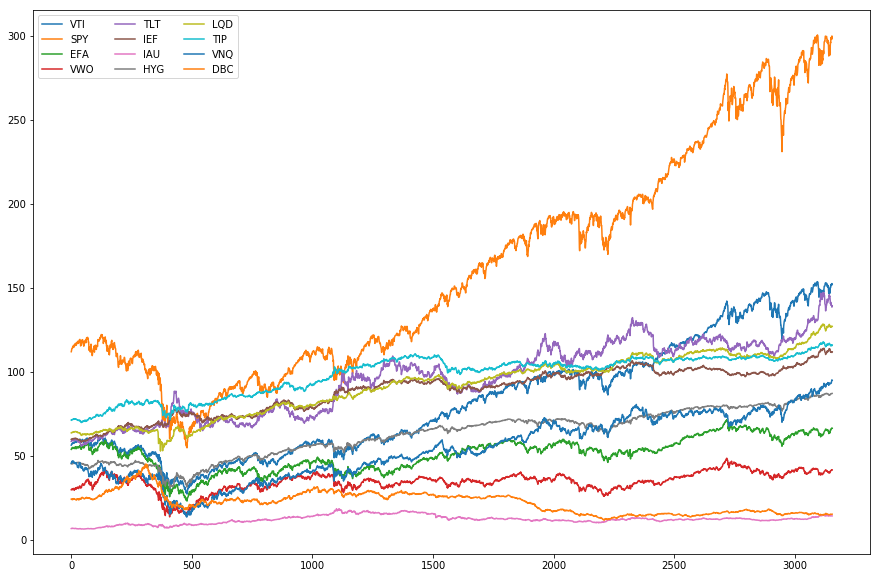

In [4]:
# Plot data

plt.figure(figsize= (15,10))
for i in range(data.shape[1]):
    plt.plot( data.values[1:, i], label = data.columns[i])
plt.legend(ncol=3)
plt.show()

In [25]:
lam = 20
max_iter = 300
N_states = 4

mdl = HMM_GraphicalLasso(alpha=lam,
                         n_clusters=N_states,
                         verbose=False,
                         max_iter=max_iter,
                         mode='scaled',
                         warm_restart=True,
                         repetitions=3,
                         n_jobs=-1)
#mdl.fit(returns_mat)

In [26]:
cluster_list = [3,4,5,6,7,8]
res = cross_validation(mdl,
       returns_mat,
       params={'alpha':np.linspace(5,100 ,20),
               'n_clusters':cluster_list},
       n_repetitions=3)



  0%|          | 0/20 [00:00<?, ?it/s]


  0%|          | 0/6 [00:00<?, ?it/s]


 17%|█▋        | 1/6 [18:12<1:31:04, 1092.81s/it]


 33%|███▎      | 2/6 [30:00<1:05:09, 977.35s/it] 


 50%|█████     | 3/6 [1:00:14<1:01:24, 1228.15s/it]


 67%|██████▋   | 4/6 [1:27:53<45:14, 1357.44s/it]  


 83%|████████▎ | 5/6 [1:59:59<25:28, 1528.08s/it]


100%|██████████| 6/6 [2:46:09<00:00, 1661.56s/it]


  5%|▌         | 1/20 [2:46:09<52:36:58, 9969.37s/it]


  0%|          | 0/6 [00:00<?, ?it/s]


 17%|█▋        | 1/6 [18:04<1:30:20, 1084.14s/it]


 33%|███▎      | 2/6 [37:05<1:13:25, 1101.31s/it]


 50%|█████     | 3/6 [1:06:08<1:04:41, 1293.81s/it]

KeyboardInterrupt: 

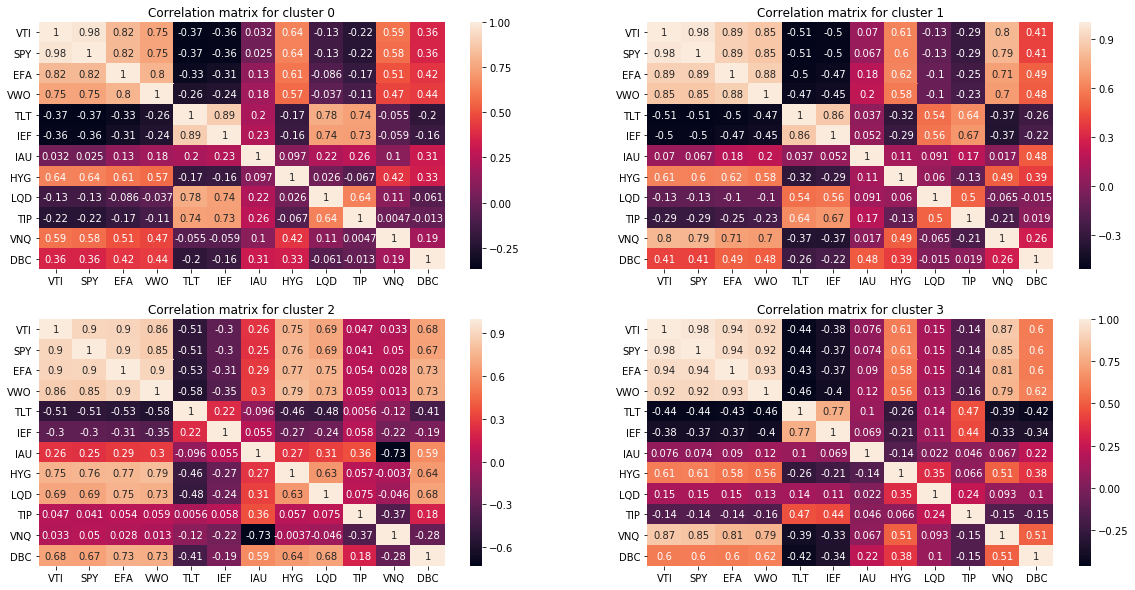

In [8]:
corr_plot(mdl.covariances_,labels = data.columns,covcorr = True)

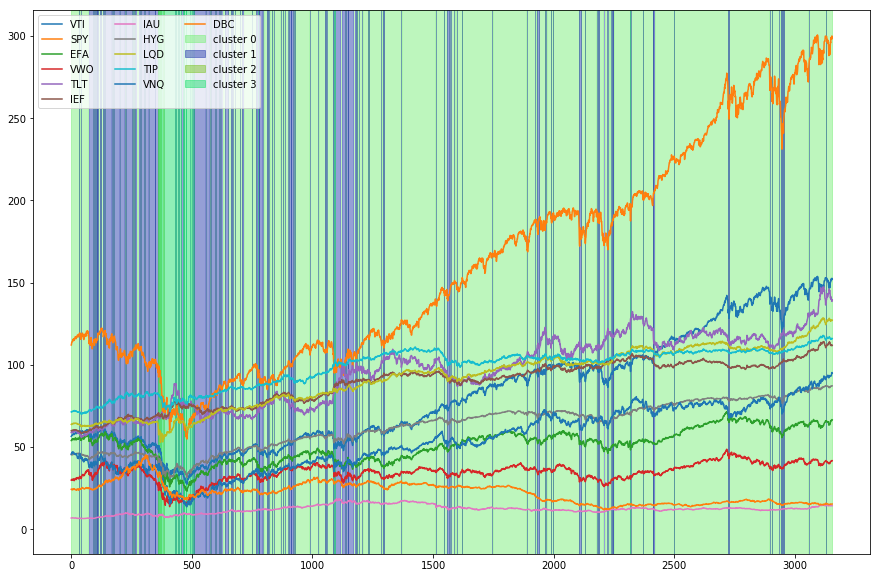

In [9]:
plot_results_cluster(data.values, mdl.labels_, ts_labels = data.columns)

In [10]:
cluster_returns_recap(mdl.means_, mdl.covariances_, data.columns)

,Cluster,TS,mean,std,Prob positive return %,Prob negative return %
0,0,VTI,0.087209,0.734028,54.593688,45.136332
1,0,SPY,0.085941,0.719239,54.620630,45.109390
2,0,EFA,0.070669,0.862645,53.129532,46.600488
3,0,VWO,0.070235,1.074718,52.470341,47.259680
4,0,TLT,0.026084,0.747611,51.256632,48.473388
5,0,IEF,0.015271,0.330378,51.708427,48.021593
6,0,IAU,0.031064,0.828301,51.360836,48.369185
7,0,HYG,0.039878,0.319095,54.837720,44.892301
8,0,LQD,0.028919,0.299626,53.709471,46.020549
9,0,TIP,0.014561,0.277127,51.960176,47.769845


100%|██████████| 1/1 [13:46<00:00, 826.43s/it]


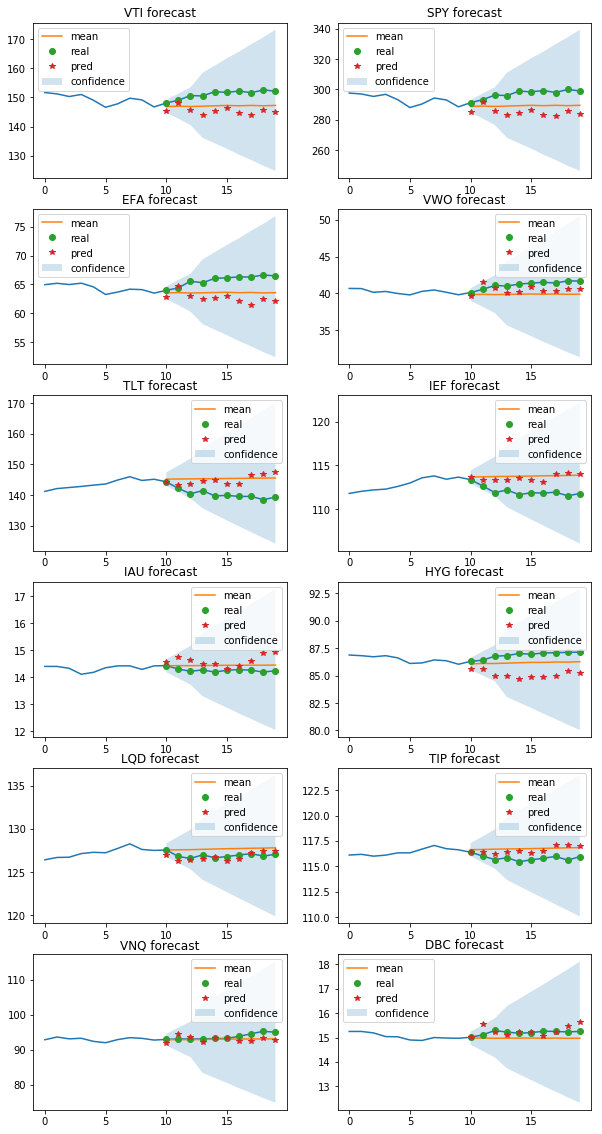

In [11]:
alpha_list = [lam]
cluster_list = [N_states]
N_pred = 10

results = pred_HMM_GMM(returns_mat,
                       data.values,
                       alpha_list,
                       cluster_list,
                       N_test = N_pred,
                       columns = data.columns,
                       meth = 'viterbi',
                       pred_meth = 'norolling',
                       recrossval = False,
                       perc_var = True)

In [12]:
returns_recap(results[-1], results[-2])

,day,TS,mean,std,Prob positive return %,Prob negative return %
0,day 1,ts 0,0.086195,0.733369,54.543109,45.186912
1,day 1,ts 1,0.084937,0.718553,54.569790,45.160230
2,day 1,ts 2,0.069071,0.861485,53.060167,46.669853
3,day 1,ts 3,0.068829,1.074670,52.418344,47.311677
4,day 1,ts 4,0.028306,0.746408,51.377533,48.352488
...,...,...,...,...,...,...
115,day 10,ts 7,0.039030,0.318461,54.742157,44.987863
116,day 10,ts 8,0.029689,0.299036,53.819272,45.910749
117,day 10,ts 9,0.015180,0.276434,52.054686,47.675334
118,day 10,ts 10,0.079199,0.909569,53.334331,46.395690


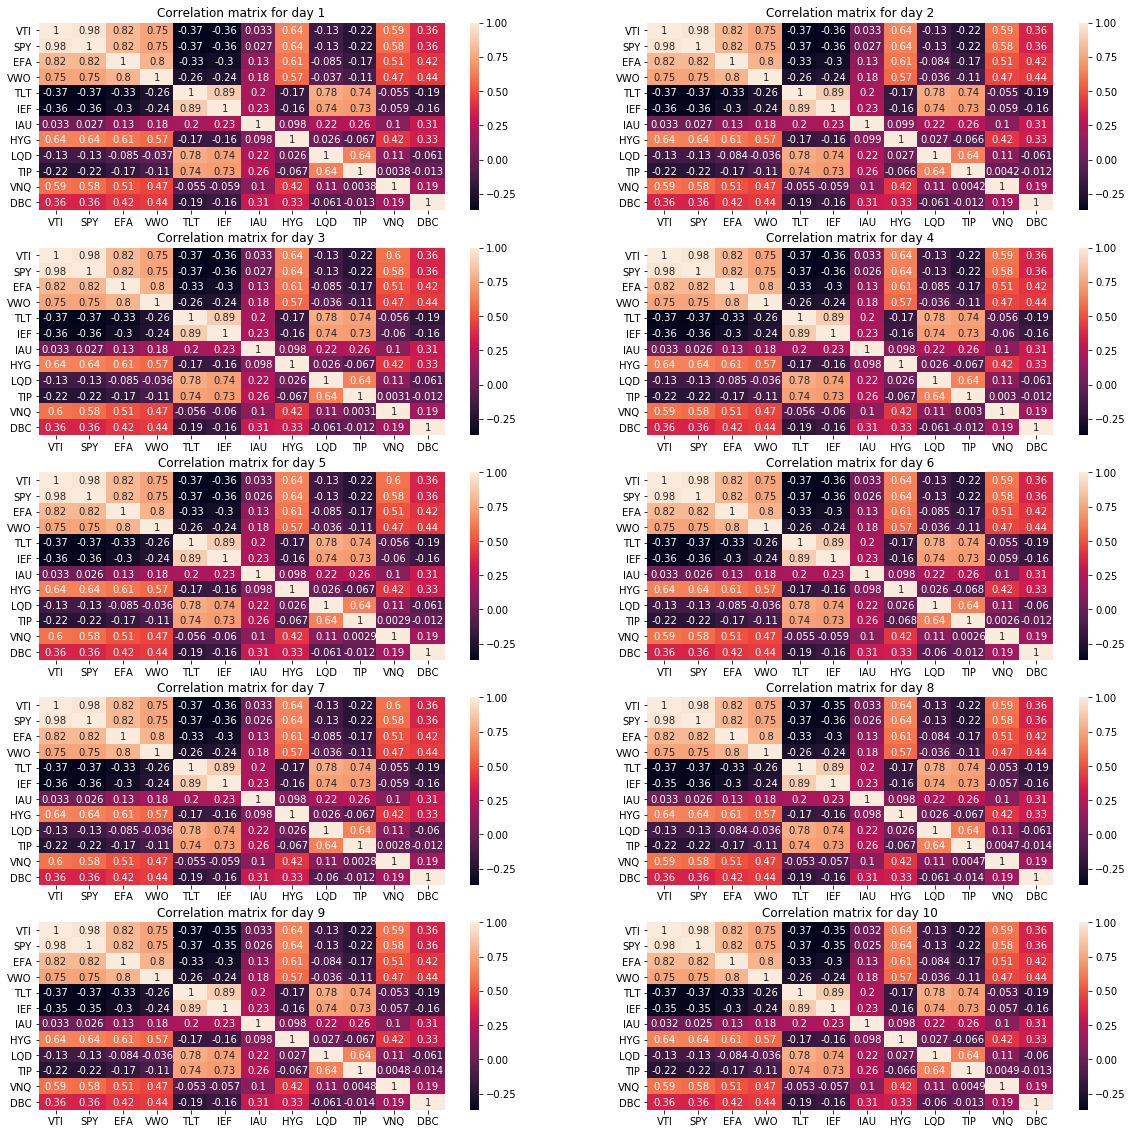

In [17]:
corr_pred_plot(results[-2],sizeplotx=20,sizeploty=20, labels=data.columns,covcorr=True)

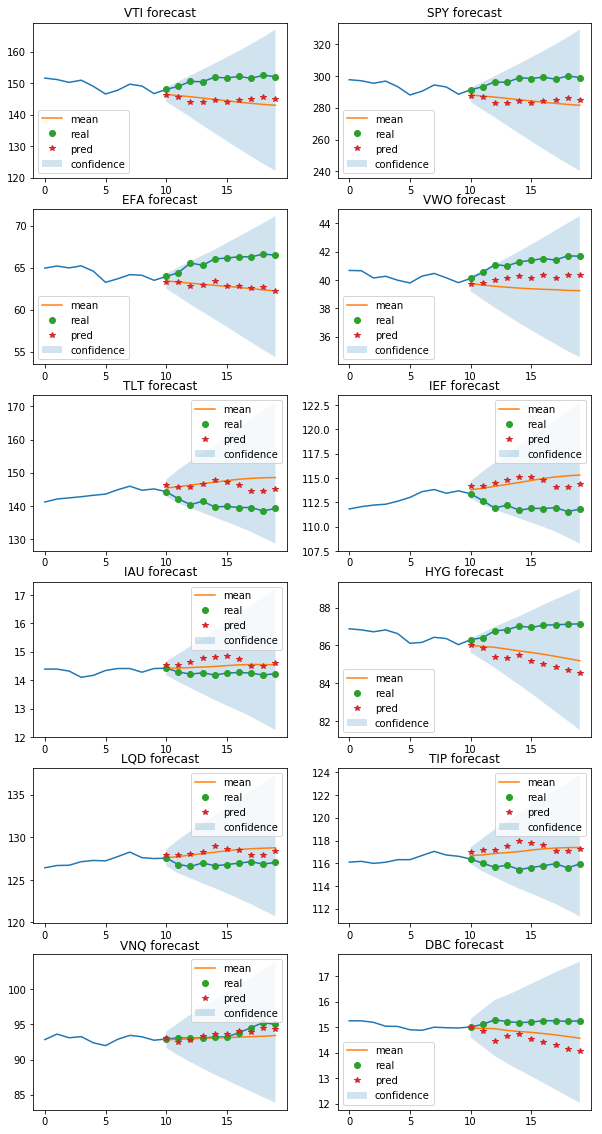

In [19]:
res = pred_from_N_past_days(returns_mat,
                            data.values,
                            N_past_days=19,
                            N_test=N_pred,
                            pred_meth = 'norolling',
                            columns = data.columns,
                            perc_var = True)

In [20]:
returns_recap(res[-1], res[-2])

,day,TS,mean,std,Prob positive return %,Prob negative return %
0,day 1,ts 0,-0.198553,0.762253,39.589610,60.140410
1,day 1,ts 1,-0.182227,0.761876,40.413223,59.316797
2,day 1,ts 2,-0.136547,0.694908,42.076111,57.653909
3,day 1,ts 3,-0.177017,0.664187,39.357064,60.372956
4,day 1,ts 4,0.187594,0.878722,58.317572,41.412449
...,...,...,...,...,...,...
115,day 10,ts 7,-0.137506,0.225987,27.008797,72.721224
116,day 10,ts 8,0.033912,0.310069,54.219499,45.510521
117,day 10,ts 9,0.015932,0.252509,52.380522,47.349498
118,day 10,ts 10,0.107503,0.509737,58.216710,41.513310


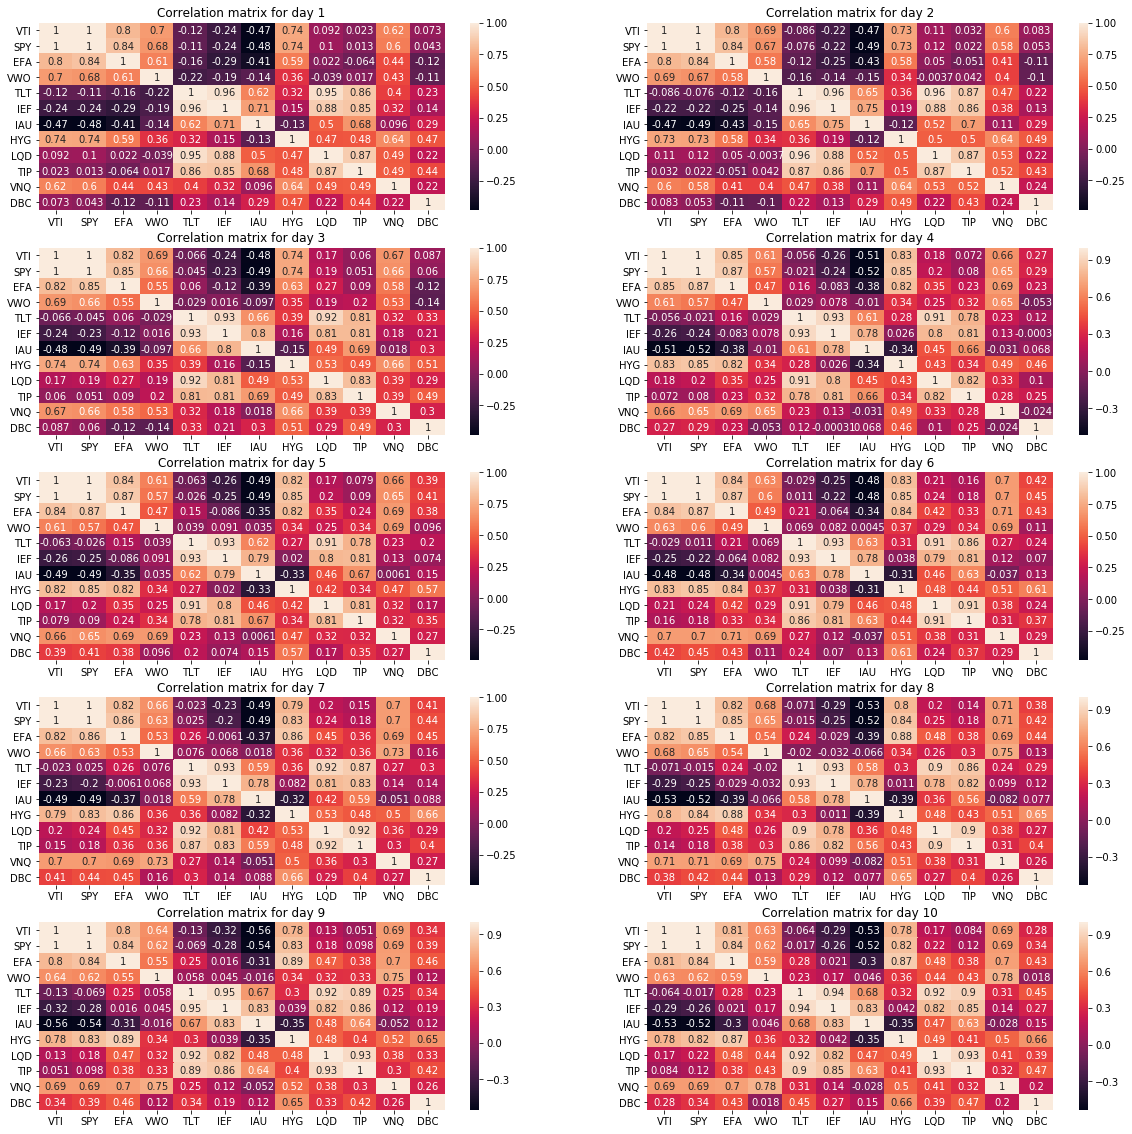

In [21]:
corr_pred_plot(res[-2],sizeplotx=20,sizeploty=20, labels=data.columns,covcorr=True)